In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# progress bar
from tqdm.notebook import tqdm

# dimensionality reduction (for visualization)
#from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# clustering
from sklearn.cluster import KMeans                   # 1. k-means
from sklearn.cluster import AgglomerativeClustering   # 2. Hierarchical Agglomerative Clustering
from sklearn.cluster import DBSCAN                    # 3. DBSCAN
from sklearn.cluster import SpectralClustering        # 4. Spectral Clustering
from sklearn.mixture import GaussianMixture
import hdbscan

from sklearn.metrics import silhouette_score 

import warnings
warnings.filterwarnings(action='ignore') 
pd.set_option('display.max_columns', None)

In [2]:
!pip install yellowbrick
!pip install kneed

In [3]:
df = pd.read_csv('../../1_modeling/data/all_merge.csv')
df = df.groupby('fk_id').sum().reset_index()
df = df.fillna(0)
df = df.set_index('fk_id')

In [4]:
df= (df+1).apply(np.log)
df.head()

,biz_cnt,co_pay,nhis_pay,nonbenefit_total_pay,carinsur_pay,etc_pay,room_pay,total_pay,nonbenefit_pay,nonbenefit_repay,appointment_cnt,fulfillment_cnt,cancel_cnt,noshow_cnt,reception_cnt,visit_cnt,fstvisit_cnt,revisit_cnt,refstvisit_cnt,carinsur_cnt,pay_tel_cnsl_cnt,simple_tel_cnsl_cnt,document_visit_cnt,room_cnt,senior_cnt,fstvisit_attrition_rate,fstvisit_3t3w_rate,nonbenefit_cnsl_cnt,nonbenefit_repay_cnsl_cnt,non_unit_pay_0,non_unit_pay_1,non_unit_pay_2,non_unit_pay_3,non_unit_pay_4,non_unit_pay_5,non_unit_pay_6,non_unit_pay_7,non_unit_pay_8,non_unit_pay_9,non_unit_pay_10,non_unit_pay_11,non_unit_repay_0,non_unit_repay_1,non_unit_repay_2,non_unit_repay_3,non_unit_repay_4,non_unit_repay_5,non_unit_repay_8,non_unit_repay_9,non_unit_repay_10
fk_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619dd27d54bfcb65d02733ff,5.627621,18.220150,18.399472,18.707771,18.314335,0.000000,0.000000,19.814191,18.076519,17.948643,8.226306,7.910591,6.733402,5.198497,7.864036,8.190354,6.364751,8.014997,5.278115,3.367296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.924256,6.411818,17.584519,15.935254,15.325405,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,13.580953,10.778977,17.475936,0.000000,15.500906,0.000000,0.000000,0.0,0.0,0.0,14.370325
619dd27d54bfcb65d0273400,5.777652,19.102891,20.127963,20.344138,18.443791,0.000000,0.000000,21.152458,20.237493,18.053035,9.745429,9.572550,7.375256,7.022868,9.758809,9.929058,7.404888,9.845594,7.160069,3.988984,0.000000,0.693147,0.000000,0.000000,8.802673,0.000000,0.000000,8.023552,5.327876,18.678693,17.471175,16.494956,0.000000,0.000000,0.0,0.0,18.08525,0.0,0.0,12.018604,15.943048,17.404438,15.066272,0.000000,0.000000,0.000000,0.0,0.0,0.0,13.318261
619dd27d54bfcb65d0273401,5.627621,17.367337,18.956821,19.251573,17.811612,14.297196,0.000000,20.012683,19.004430,17.724027,8.398184,8.142063,6.001415,6.400257,8.144969,8.800867,6.828712,8.651199,6.467699,4.007333,1.386294,4.543295,1.098612,0.000000,6.593045,2.933979,3.007409,6.683361,6.810142,16.747016,18.422655,14.314062,13.612171,14.285515,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,14.813934,0.000000,14.376249,11.571204,15.160983,0.0,0.0,0.0,17.335735
619dd27d54bfcb65d0273402,5.752573,18.845641,19.628842,19.619182,20.199468,17.964979,18.652994,21.111836,19.611612,0.000000,9.926178,9.684523,8.062748,7.102499,9.658162,9.981698,7.653969,9.879144,7.033506,6.692084,0.000000,0.000000,0.000000,5.690359,7.929126,0.000000,0.000000,6.376727,0.000000,18.700830,16.427050,0.000000,12.899222,0.000000,0.0,0.0,0.00000,0.0,0.0,12.765691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
619dd27d54bfcb65d0273404,5.693732,17.646326,18.928118,18.415174,17.532577,0.000000,0.000000,19.682180,18.404248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.072916,6.527958,8.985195,7.027315,3.637586,0.000000,0.000000,0.000000,0.000000,8.092851,2.322388,2.413232,7.450661,0.000000,17.690418,15.960494,14.554583,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,15.535965,8.006701,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df)
X = pd.DataFrame(data=scaled, columns=df.columns, index=df.index)

# kmeans clustering

In [6]:
# PCA 적용
from sklearn.decomposition import PCA

pca = PCA(n_components=0.7,random_state=42) # PCA(n_components=6)
pca_data = pca.fit_transform(X)

In [7]:
pca_data.shape

(124, 6)

In [8]:
sses = []
scores = []
N = list(range(2, 10))  # check between K=2 to K=10

for n_clusters in tqdm(N):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    preds = model.fit_predict(pca_data)
    sse = model.inertia_
    score = silhouette_score(pca_data, preds)
    sses.append(sse)
    scores.append(score)

  0%|          | 0/8 [00:00<?, ?it/s]

##  최적 k 찾기 _ elbow

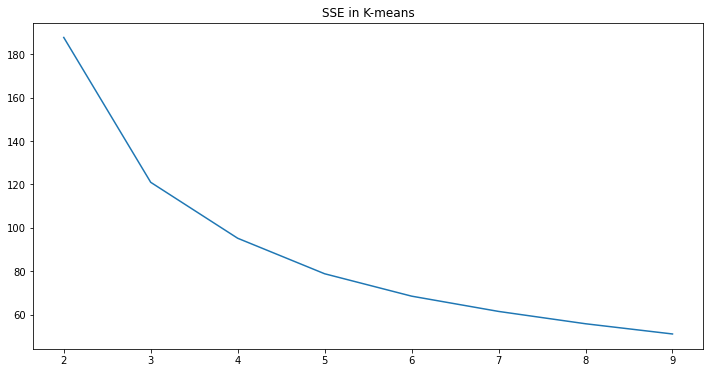

In [9]:
plt.figure(figsize=(12, 6))
plt.title("SSE in K-means")
sns.lineplot(x=N, y=sses)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


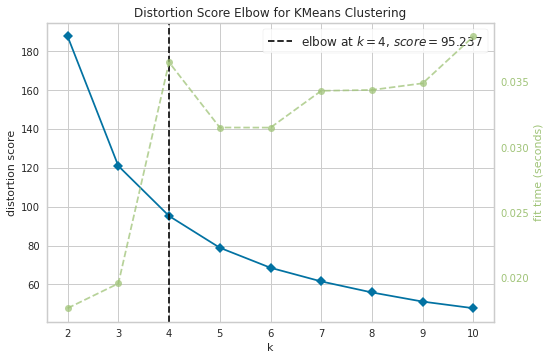

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,11))
visualizer.fit(pca_data)
visualizer.poof() 

최적의 k : 4
최적의 k의 y값 : 95.237


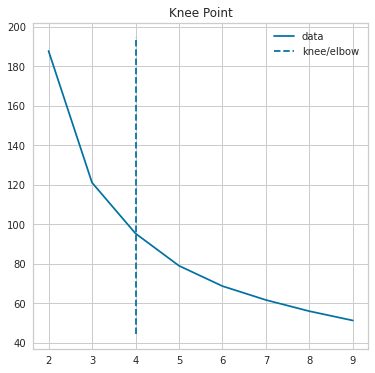

In [11]:
# 아래 parameter를 참고하여 kneed 모듈을 사용하여 자동으로 elbow값을 찾아보세요.
from kneed import KneeLocator
"""
[KneeLocator parameter 참고]
curve (str) – If ‘concave’, algorithm will detect knees. If ‘convex’, it will detect elbows.
direction (str) – one of {“increasing”, “decreasing”}
"""
kneedle = KneeLocator(x=N, y=sses, S=1.0, curve="convex", direction="decreasing")
print(f"최적의 k : {round(kneedle.elbow, 3)}")
print(f"최적의 k의 y값 : {round(kneedle.elbow_y, 3)}")

# 볼록 curve plot의 경우, 아래와 같이 knee를 찾습니다.
# print(round(kneedle.knee, 3))
# print(round(kneedle.knee_y, 3))

kneedle.plot_knee()

##  최적 k 찾기 _ Silhouette

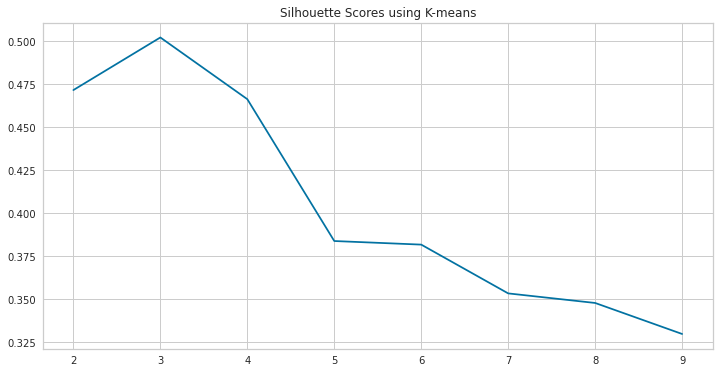

In [12]:
# Silhouette
plt.figure(figsize=(12, 6))
plt.title("Silhouette Scores using K-means")
sns.lineplot(x=N, y=scores)
plt.show()

In [13]:
N

[2, 3, 4, 5, 6, 7, 8, 9]

2


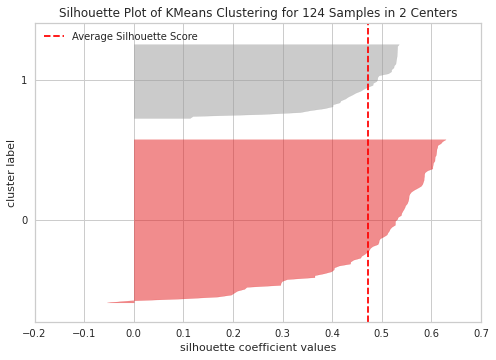

3


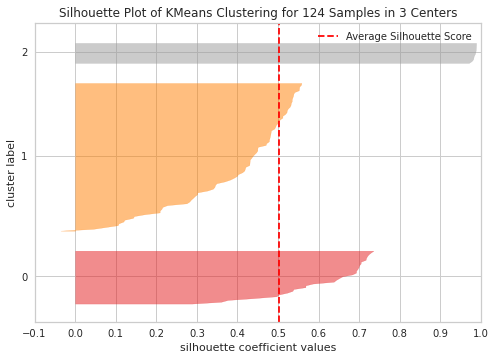

4


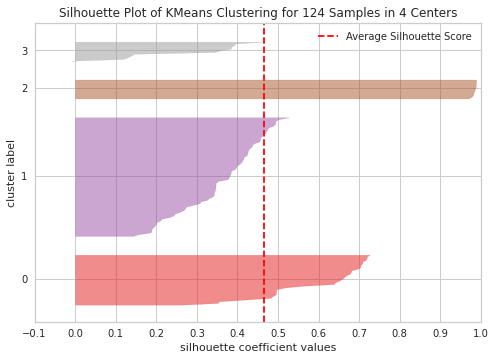

5


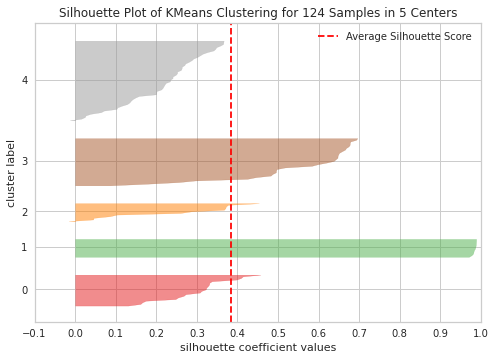

6


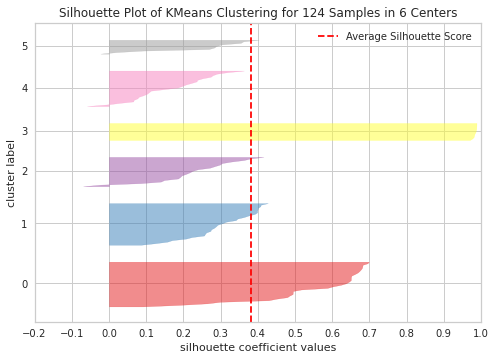

7


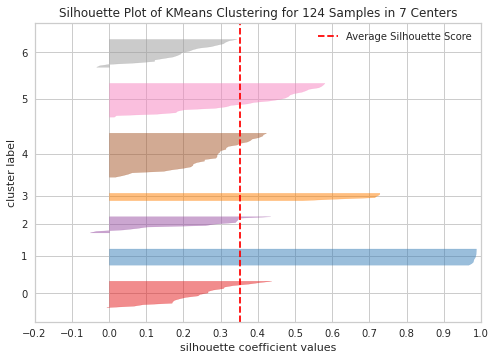

8


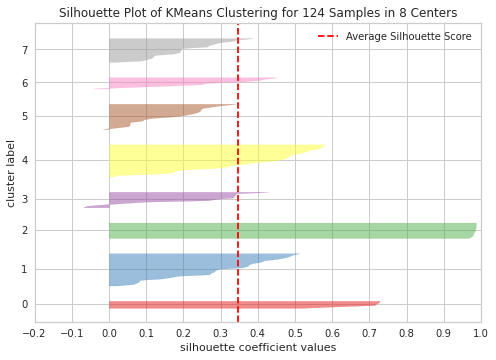

9


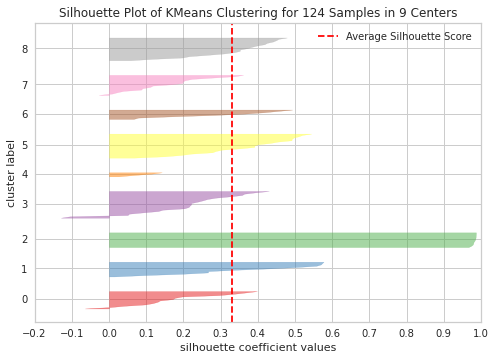

In [14]:
from yellowbrick.cluster import SilhouetteVisualizer

# k의 범위를 지정해주세요.
# [주의!] 최소 2개이상의 label/cluster가 있어야 합니다.

for i in N:
    print(i)
    km = KMeans(n_clusters=i, init="k-means++",random_state=42)
    visualizer = SilhouetteVisualizer(km)
    visualizer.fit(pca_data)
    visualizer.poof()

In [15]:
# we segment 28,317 users into 8 groups by using K-means clustering.

model = KMeans(n_clusters=4,random_state=42)
preds = model.fit_predict(pca_data)  # no needed 'y'
print("SSE : ", model.inertia_)
print("Silhouette Score : %.4f" % silhouette_score(pca_data, preds))

SSE :  95.2372849734041
Silhouette Score : 0.4662


In [16]:
# df = pd.read_csv('../../1.modeling/data/df_excel_sum')
# df = df.set_index('fk_id')

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne_data = tsne.fit_transform(pca_data)
tsne_data

array([[ -6.557076  ,  -7.701883  ],
       [ -6.6255336 ,  -6.9509645 ],
       [ -1.9330068 , -10.070115  ],
       [ -0.13475047,  -4.707539  ],
       [ -5.4281187 ,  -2.0644417 ],
       [ -1.1120346 ,  -7.360495  ],
       [ -7.337451  ,  -6.8031764 ],
       [ -6.013881  ,  -4.330058  ],
       [ -5.3580537 ,  -2.1210368 ],
       [  3.3930767 ,   0.22984779],
       [ -6.367536  ,  -2.961546  ],
       [ -6.5471034 ,  -6.9354    ],
       [ -5.131384  ,  -4.231807  ],
       [ -6.2623596 ,  -2.9480374 ],
       [ -3.9308243 ,  -3.35398   ],
       [ -3.7203333 ,  -5.6188407 ],
       [ -2.1791363 ,  -7.1215105 ],
       [ -2.0365107 ,  -4.7217937 ],
       [  3.1539514 ,  -0.6080528 ],
       [ -2.5974057 ,  -4.8368216 ],
       [ -4.9944763 ,  -7.150276  ],
       [ -1.9371516 ,  -4.3132353 ],
       [ -6.0108776 ,  -2.6886528 ],
       [ -4.087525  ,  -5.9867992 ],
       [ -6.497907  ,  -7.345181  ],
       [ -1.7756363 ,  -6.5690913 ],
       [ -1.1852728 ,  -5.1772976 ],
 

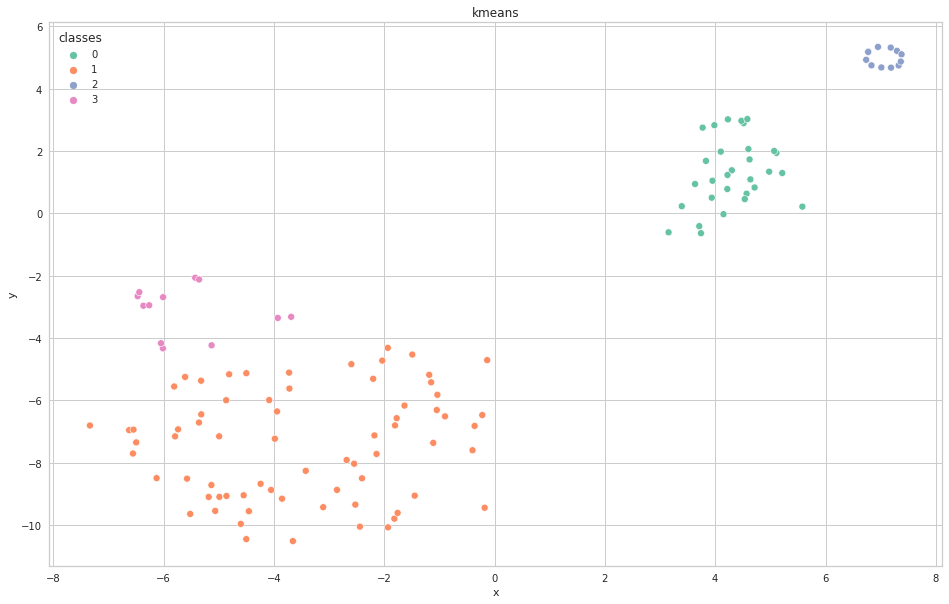

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2).fit_transform(train_x)

tsne_df = pd.DataFrame({'x': tsne_data[:, 0], 'y':tsne_data[:, 1], 'classes':preds})

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    palette = 'Set2',
    data = tsne_df,
    legend = "full",
#     alpha = 0.4
)

plt.title("kmeans")

# plt.savefig('HW6/TSNE.png', bbox_inches='tight')  
plt.show()

In [19]:
# df = pd.read_csv('../../1_modeling/data/all_merge.csv')
# df = df.groupby('fk_id').sum().reset_index()
# df = df.fillna(0)
# df = df.assign(target = preds)
# df 

# df.to_csv('../../1_modeling/data/all_merge_km_T.csv',index=False)

# GMM ciustering

SSE :  [[ 1.06599774e+00  8.06695674e-01  1.57004586e-01 -1.82716841e-01
   3.76091183e-02 -2.16774247e-01]
 [-9.60419600e-01 -9.01035498e-02 -1.48859620e-01  5.79829857e-02
  -2.16153302e-04  4.10266443e-02]
 [ 3.13213658e+00 -8.81441591e-01 -5.32820089e-01  1.99216326e-01
   2.16631168e-02  2.10874017e-01]
 [-1.19011994e-01 -6.61040224e-01  1.12304392e+00 -9.43590538e-02
  -1.25711313e-01  9.67510305e-02]]
Silhouette Score : 0.4747


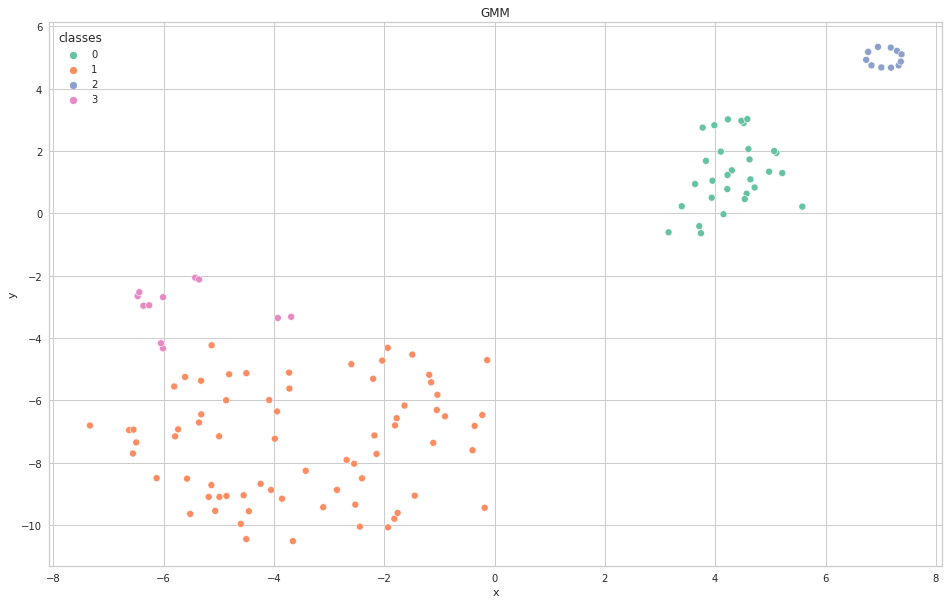

In [20]:
# 데이터 불러오기
df = pd.read_csv('../../1_modeling/data/all_merge.csv')
df = df.groupby('fk_id').sum().reset_index()
df = df.set_index('fk_id')


# 로그화
df= (df+1).apply(np.log)


# 데이터스케일링
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df)
X = pd.DataFrame(data=scaled, columns=df.columns, index=df.index)


# PCA 적용
from sklearn.decomposition import PCA

pca = PCA(n_components=0.7,random_state=42) # PCA(n_components=6)
pca_data = pca.fit_transform(X)


# GMM model
model = GaussianMixture(n_components=4,random_state=42)
preds = model.fit_predict(pca_data)  # no needed 'y'
print("SSE : ", model.means_)
print("Silhouette Score : %.4f" % silhouette_score(pca_data, preds))


# 차원축소
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne_data = tsne.fit_transform(pca_data)


# 시각화
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_df = pd.DataFrame({'x': tsne_data[:, 0], 'y':tsne_data[:, 1], 'classes':preds})

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    palette = 'Set2',
    data = tsne_df,
    legend = "full",
#     alpha = 0.4
)

plt.title("GMM")

# plt.savefig('HW6/TSNE.png', bbox_inches='tight')  
plt.show()

In [21]:
# df = pd.read_csv('../../1_modeling/data/all_merge.csv')
# df = df.groupby('fk_id').sum().reset_index()
# df = df.fillna(0)
# df = df.assign(target = preds)
# df

# df.to_csv('../../1_modeling/data/all_merge_gmm_T.csv',index=False)

# Hierarchical clustering

In [22]:
# 데이터 불러오기
df = pd.read_csv('../../1_modeling/data/all_merge.csv')
df = df.groupby('fk_id').sum().reset_index()
df = df.set_index('fk_id')


# 로그화
df= (df+1).apply(np.log)


# 데이터스케일링
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df)
X = pd.DataFrame(data=scaled, columns=df.columns, index=df.index)


# PCA 적용
from sklearn.decomposition import PCA

pca = PCA(n_components=0.7,random_state=42) # PCA(n_components=6)
pca_data = pca.fit_transform(X)

In [23]:
# dendrogram을 그리기 위한 matplotlib와 scipy의 dendrogram import.
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def create_linkage(model):
  # 각 노드에 총 point수를 계산하기.
  counts = np.zeros(model.children_.shape[0]) # children 길이만큼 0 채운 array.
  n_samples = len(model.labels_) # 각 point의 cluster label.
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
  return linkage_matrix

In [24]:
aggl_dend = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
preds = aggl_dend.fit(pca_data)

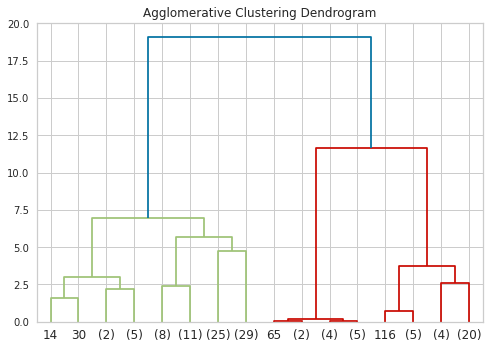

In [25]:
plt.title('Agglomerative Clustering Dendrogram')
linkage_matrix = create_linkage(preds)
dendrogram(linkage_matrix, truncate_mode="level", p=3)
plt.show()

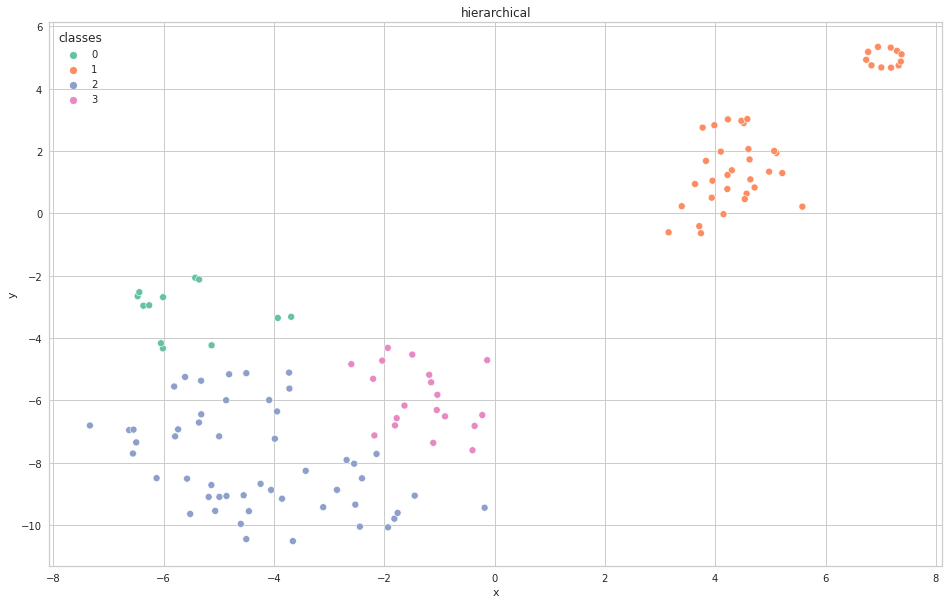

In [26]:
# aggl model
aggl = AgglomerativeClustering(n_clusters=4, linkage="average", affinity="cosine")
preds = aggl.fit_predict(pca_data)

# 차원축소
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne_data = tsne.fit_transform(pca_data)


# 시각화
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_df = pd.DataFrame({'x': tsne_data[:, 0], 'y':tsne_data[:, 1], 'classes':preds})

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    palette = 'Set2',
    data = tsne_df,
    legend = "full",
#     alpha = 0.4
)

plt.title("hierarchical")

# plt.savefig('HW6/TSNE.png', bbox_inches='tight')  
plt.show()

In [27]:
# df = pd.read_csv('../../1_modeling/data/all_merge.csv')
# df = df.groupby('fk_id').sum().reset_index()
# df = df.fillna(0)
# df = df.assign(target = preds)
# df

# df.to_csv('../../1_modeling/data/all_merge_aggl_T.csv',index=False)

# DBSCAN clustering

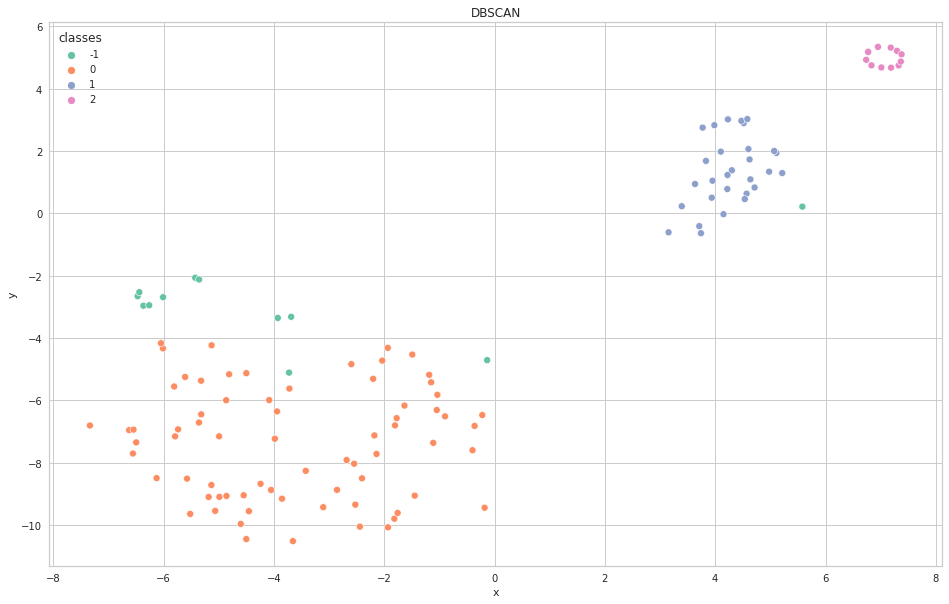

In [28]:
# 데이터 불러오기
df = pd.read_csv('../../1_modeling/data/all_merge.csv')
df = df.groupby('fk_id').sum().reset_index()
df = df.set_index('fk_id')


# 로그화
df= (df+1).apply(np.log)


# 데이터스케일링
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df)
X = pd.DataFrame(data=scaled, columns=df.columns, index=df.index)


# PCA 적용
from sklearn.decomposition import PCA

pca = PCA(n_components=0.7,random_state=42) # PCA(n_components=6)
pca_data = pca.fit_transform(X)


# DBSCAN model
dbscan = DBSCAN(eps=0.947, min_samples=5)
preds = dbscan.fit_predict(pca_data)


# 차원축소
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne_data = tsne.fit_transform(pca_data)


# 시각화
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_df = pd.DataFrame({'x': tsne_data[:, 0], 'y':tsne_data[:, 1], 'classes':preds})

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    palette = 'Set2',
    data = tsne_df,
    legend = "full",
#     alpha = 0.4
)

plt.title("DBSCAN")

# plt.savefig('HW6/TSNE.png', bbox_inches='tight')  
plt.show()

# HDBSCAN

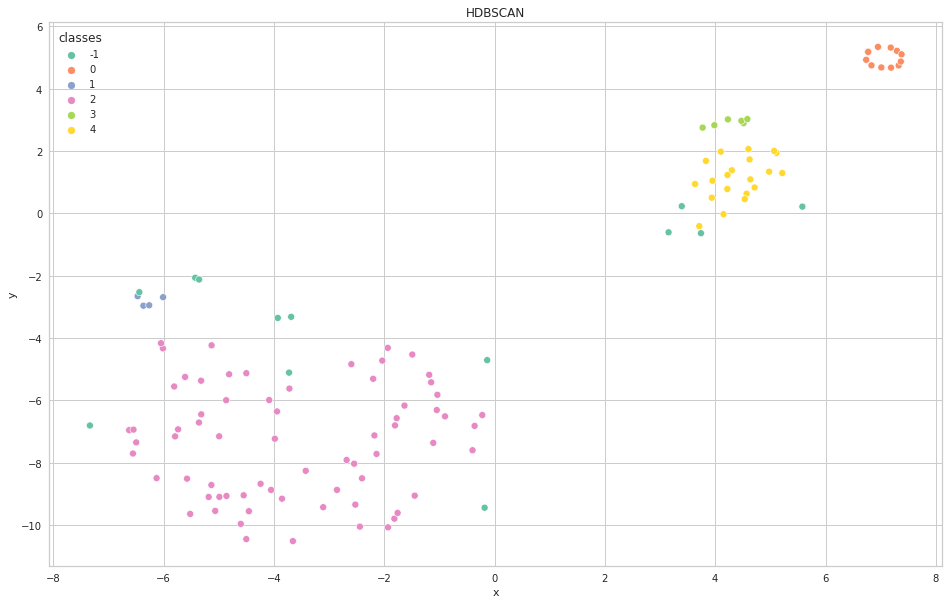

In [29]:
# 데이터 불러오기
df = pd.read_csv('../../1_modeling/data/all_merge.csv')
df = df.groupby('fk_id').sum().reset_index()
df = df.set_index('fk_id')


# 로그화
df= (df+1).apply(np.log)


# 데이터스케일링
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df)
X = pd.DataFrame(data=scaled, columns=df.columns, index=df.index)


# PCA 적용
from sklearn.decomposition import PCA

pca = PCA(n_components=0.7,random_state=42) # PCA(n_components=6)
pca_data = pca.fit_transform(X)


# DBSCAN model
hdbscan_model = hdbscan.HDBSCAN()
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=3,min_samples=2)
preds = hdbscan_model.fit_predict(pca_data)
preds 


# 차원축소
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
tsne_data = tsne.fit_transform(pca_data)


# 시각화
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_df = pd.DataFrame({'x': tsne_data[:, 0], 'y':tsne_data[:, 1], 'classes':preds})

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    palette = 'Set2',
    data = tsne_df,
    legend = "full",
#     alpha = 0.4
)

plt.title("HDBSCAN")

# plt.savefig('HW6/TSNE.png', bbox_inches='tight')  
plt.show()

# correlation

In [30]:
df = pd.read_csv('/home/team_1/1_modeling/data/all_merge.csv')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


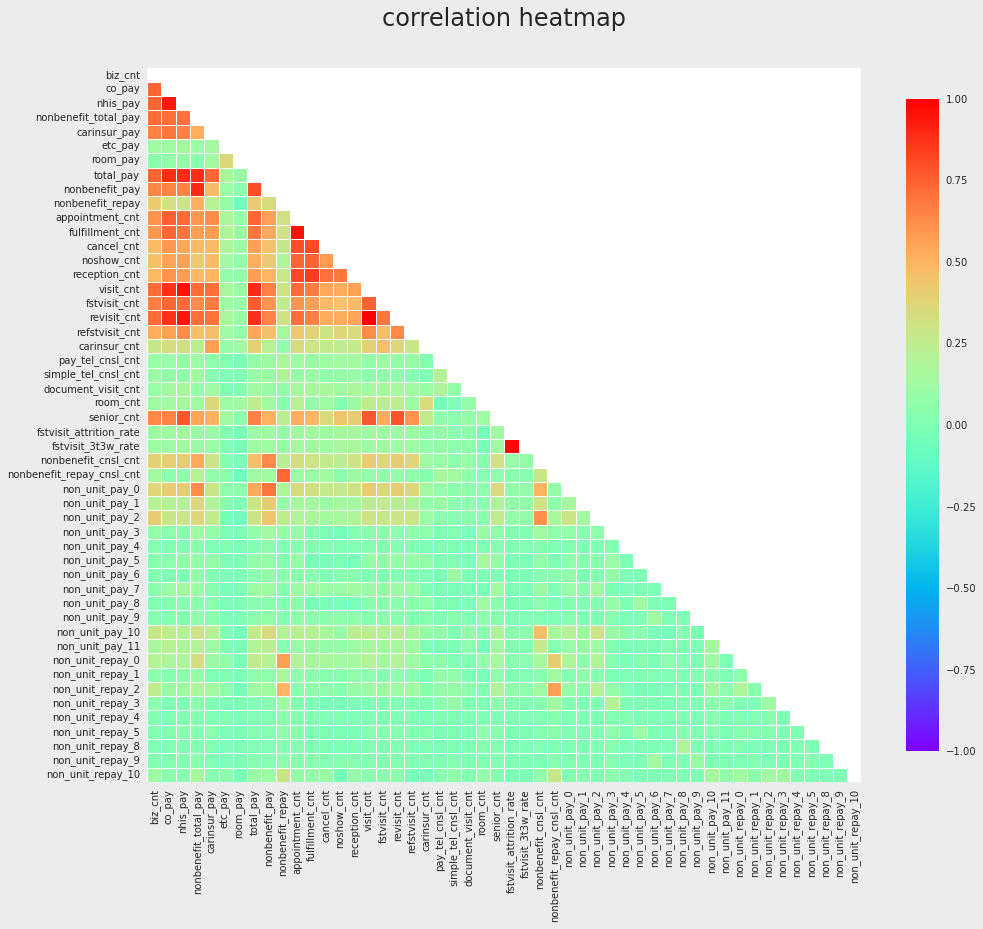

In [31]:
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 16), facecolor='#EAECEE')
cmap = sns.color_palette("rainbow", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

ax.set_title('correlation heatmap', fontsize=24, y= 1.05)
colorbar = ax.collections[0].colorbar

# plt.savefig('../corr_graph/all_merge.png')

In [32]:
corr_matrix = df.corr()
corr_matrix[abs(corr_matrix)>=0.7]

,biz_cnt,co_pay,nhis_pay,nonbenefit_total_pay,carinsur_pay,etc_pay,room_pay,total_pay,nonbenefit_pay,nonbenefit_repay,appointment_cnt,fulfillment_cnt,cancel_cnt,noshow_cnt,reception_cnt,visit_cnt,fstvisit_cnt,revisit_cnt,refstvisit_cnt,carinsur_cnt,pay_tel_cnsl_cnt,simple_tel_cnsl_cnt,document_visit_cnt,room_cnt,senior_cnt,fstvisit_attrition_rate,fstvisit_3t3w_rate,nonbenefit_cnsl_cnt,nonbenefit_repay_cnsl_cnt,non_unit_pay_0,non_unit_pay_1,non_unit_pay_2,non_unit_pay_3,non_unit_pay_4,non_unit_pay_5,non_unit_pay_6,non_unit_pay_7,non_unit_pay_8,non_unit_pay_9,non_unit_pay_10,non_unit_pay_11,non_unit_repay_0,non_unit_repay_1,non_unit_repay_2,non_unit_repay_3,non_unit_repay_4,non_unit_repay_5,non_unit_repay_8,non_unit_repay_9,non_unit_repay_10
biz_cnt,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
co_pay,NaN,1.000000,0.890368,NaN,NaN,NaN,NaN,0.745228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.817964,NaN,0.807140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nhis_pay,NaN,0.890368,1.000000,NaN,NaN,NaN,NaN,0.752913,NaN,NaN,0.707201,NaN,NaN,NaN,NaN,0.915403,NaN,0.910150,NaN,NaN,NaN,NaN,NaN,NaN,0.751473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nonbenefit_total_pay,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.854162,0.918143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carinsur_pay,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
etc_pay,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
room_pay,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_pay,NaN,0.745228,0.752913,0.854162,NaN,NaN,NaN,1.000000,0.806924,NaN,0.701887,NaN,NaN,NaN,NaN,0.784109,NaN,0.771636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nonbenefit_pay,NaN,NaN,NaN,0.918143,NaN,NaN,NaN,0.806924,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nonbenefit_repay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 군집화 해석

In [33]:
df_km = pd.read_csv('../../1_modeling/data/all_merge_km_T.csv')
df_aggl = pd.read_csv('../../1_modeling/data/all_merge_aggl_T.csv')
df_gmm = pd.read_csv('../../1_modeling/data/all_merge_gmm_T.csv')
df_db = pd.read_csv('../../1_modeling/data/all_merge_DBSCAN.csv')
df_hdb = pd.read_csv('../../1_modeling/data/all_merge_hdb_T.csv')

In [34]:
target_cols= ['total_pay','co_pay','nhis_pay','nonbenefit_pay','nonbenefit_repay','carinsur_pay','target' ]
imp_cols = ['total_pay','co_pay','nhis_pay','nonbenefit_pay','nonbenefit_repay','carinsur_pay']
cnt_cols = ['total_pay', 'fulfillment_cnt', 'fstvisit_cnt', 'revisit_cnt','target']
string_cols = ['total_pay','nonbenefit_pay','co_pay','nhis_pay','nonbenefit_total_pay','carinsur_pay','target' ]

## kmeans clustering 해석

<AxesSubplot:xlabel='target', ylabel='carinsur_pay'>

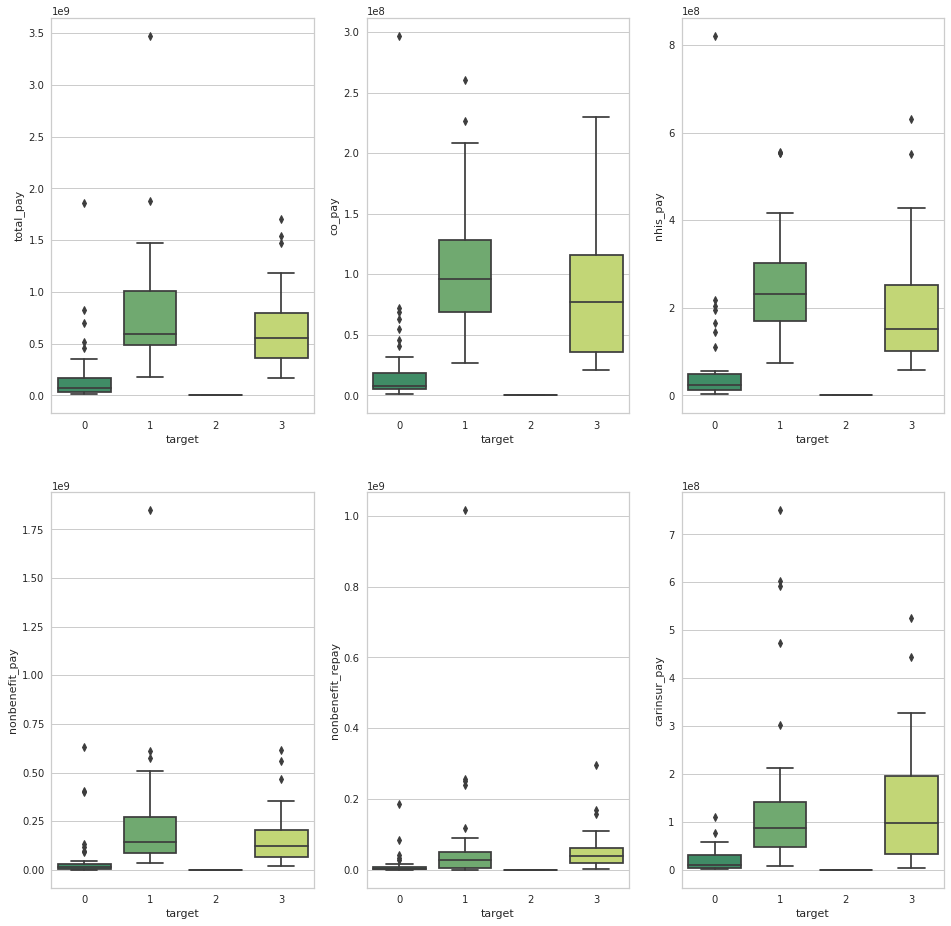

In [35]:
fig, axes = plt.subplots(2,3,figsize=(16,16))



sns.boxplot(ax=axes[0,0], data=df_km, x= 'target', y='total_pay', palette='summer')
sns.boxplot(ax=axes[0,1], data=df_km, x= 'target', y='co_pay', palette='summer')
sns.boxplot(ax=axes[0,2], data=df_km, x= 'target', y='nhis_pay', palette='summer')
sns.boxplot(ax=axes[1,0], data=df_km, x= 'target', y='nonbenefit_pay', palette='summer')
sns.boxplot(ax=axes[1,1], data=df_km, x= 'target', y='nonbenefit_repay', palette='summer')
sns.boxplot(ax=axes[1,2], data=df_km, x= 'target', y='carinsur_pay', palette='summer')

## GMM clustering 해석

<AxesSubplot:xlabel='target', ylabel='carinsur_pay'>

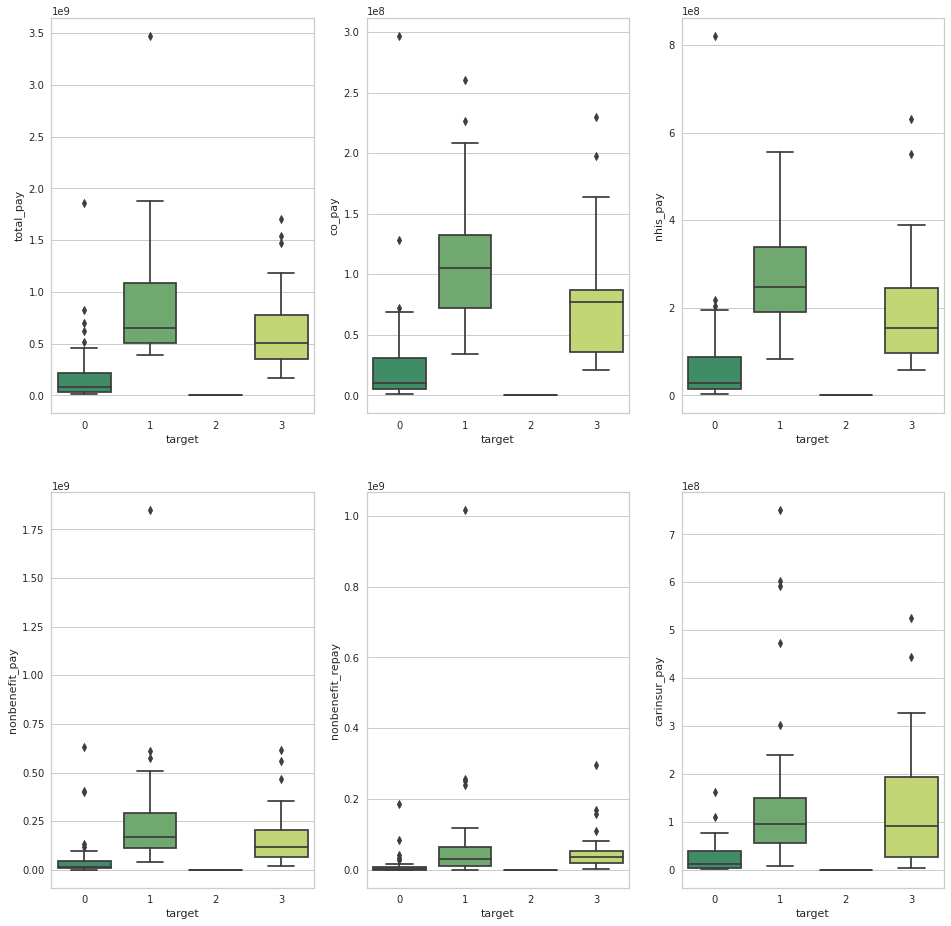

In [36]:
fig, axes = plt.subplots(2,3,figsize=(16,16))


sns.boxplot(ax=axes[0,0], data=df_gmm, x= 'target', y='total_pay', palette='summer')
sns.boxplot(ax=axes[0,1], data=df_gmm, x= 'target', y='co_pay', palette='summer')
sns.boxplot(ax=axes[0,2], data=df_gmm, x= 'target', y='nhis_pay', palette='summer')
sns.boxplot(ax=axes[1,0], data=df_gmm, x= 'target', y='nonbenefit_pay', palette='summer')
sns.boxplot(ax=axes[1,1], data=df_gmm, x= 'target', y='nonbenefit_repay', palette='summer')
sns.boxplot(ax=axes[1,2], data=df_gmm, x= 'target', y='carinsur_pay', palette='summer')

## Hierarchical clustering 해석

<AxesSubplot:xlabel='target', ylabel='carinsur_pay'>

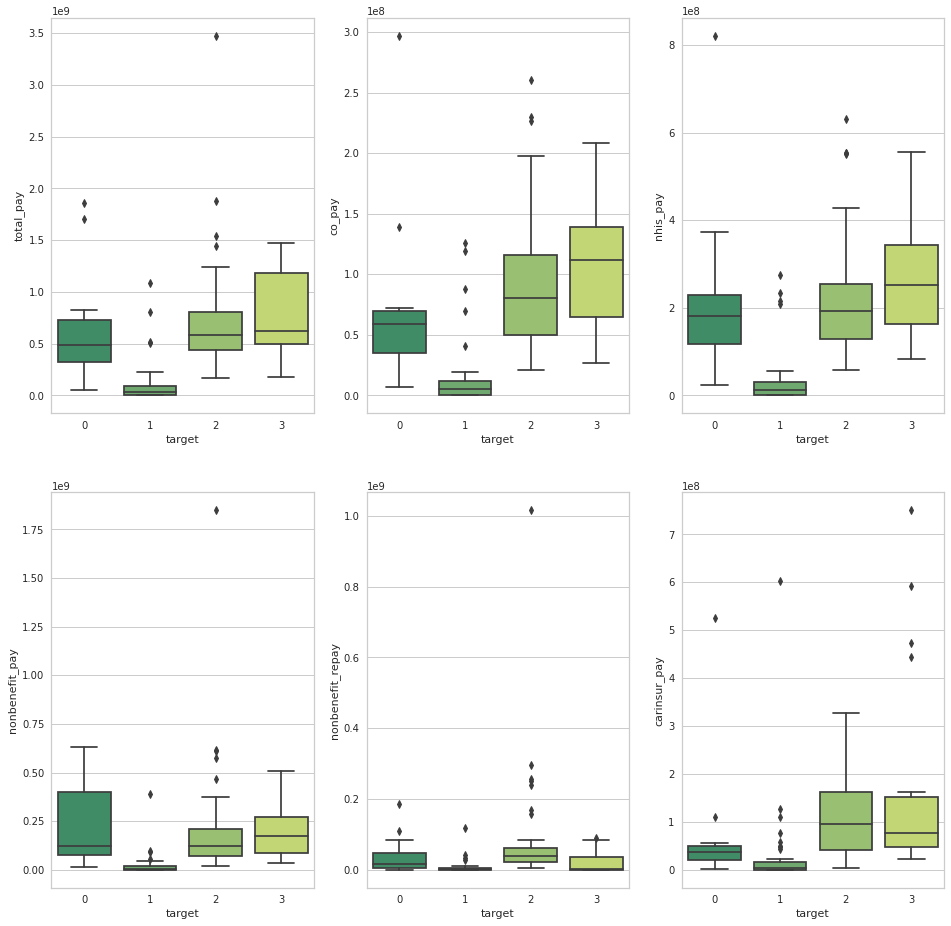

In [37]:
fig, axes = plt.subplots(2,3,figsize=(16,16))


sns.boxplot(ax=axes[0,0], data=df_aggl, x= 'target', y='total_pay', palette='summer')
sns.boxplot(ax=axes[0,1], data=df_aggl, x= 'target', y='co_pay', palette='summer')
sns.boxplot(ax=axes[0,2], data=df_aggl, x= 'target', y='nhis_pay', palette='summer')
sns.boxplot(ax=axes[1,0], data=df_aggl, x= 'target', y='nonbenefit_pay', palette='summer')
sns.boxplot(ax=axes[1,1], data=df_aggl, x= 'target', y='nonbenefit_repay', palette='summer')
sns.boxplot(ax=axes[1,2], data=df_aggl, x= 'target', y='carinsur_pay', palette='summer')

## DBSCAN clustering 해석

<AxesSubplot:xlabel='target', ylabel='carinsur_pay'>

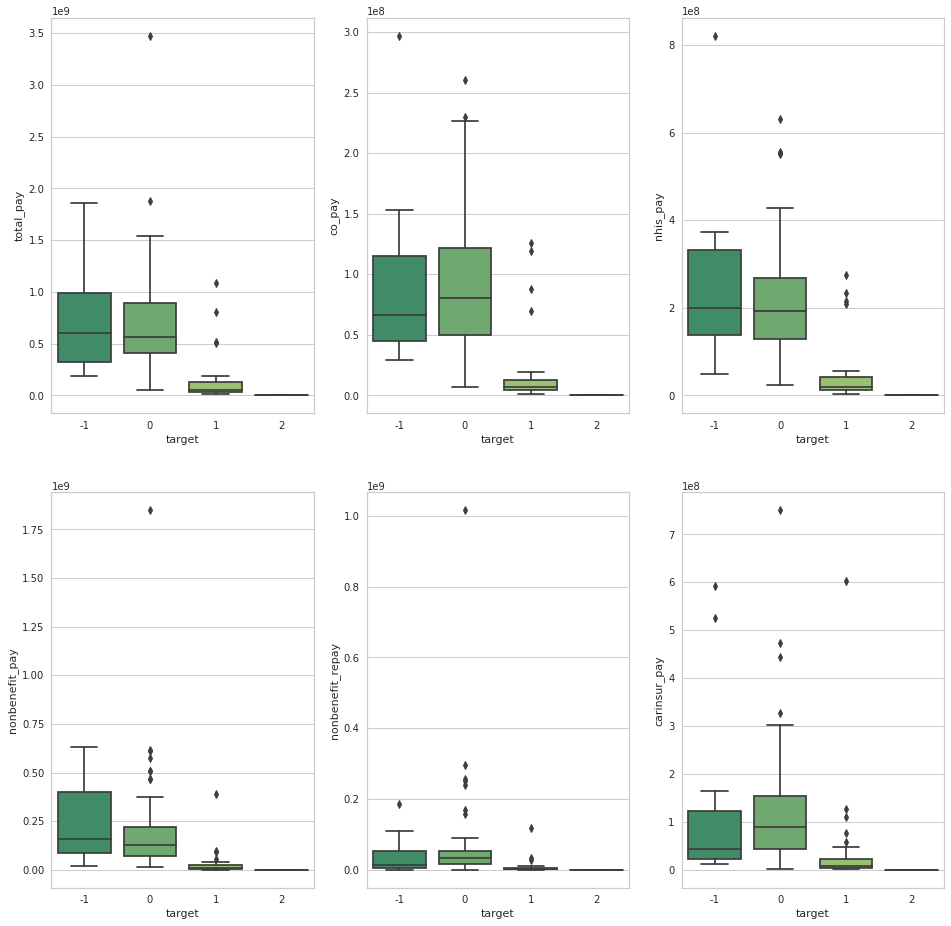

In [38]:
fig, axes = plt.subplots(2,3,figsize=(16,16))


sns.boxplot(ax=axes[0,0], data=df_db, x= 'target', y='total_pay', palette='summer')
sns.boxplot(ax=axes[0,1], data=df_db, x= 'target', y='co_pay', palette='summer')
sns.boxplot(ax=axes[0,2], data=df_db, x= 'target', y='nhis_pay', palette='summer')
sns.boxplot(ax=axes[1,0], data=df_db, x= 'target', y='nonbenefit_pay', palette='summer')
sns.boxplot(ax=axes[1,1], data=df_db, x= 'target', y='nonbenefit_repay', palette='summer')
sns.boxplot(ax=axes[1,2], data=df_db, x= 'target', y='carinsur_pay', palette='summer')

## HDBSCAN clustering 해석

<AxesSubplot:xlabel='target', ylabel='carinsur_pay'>

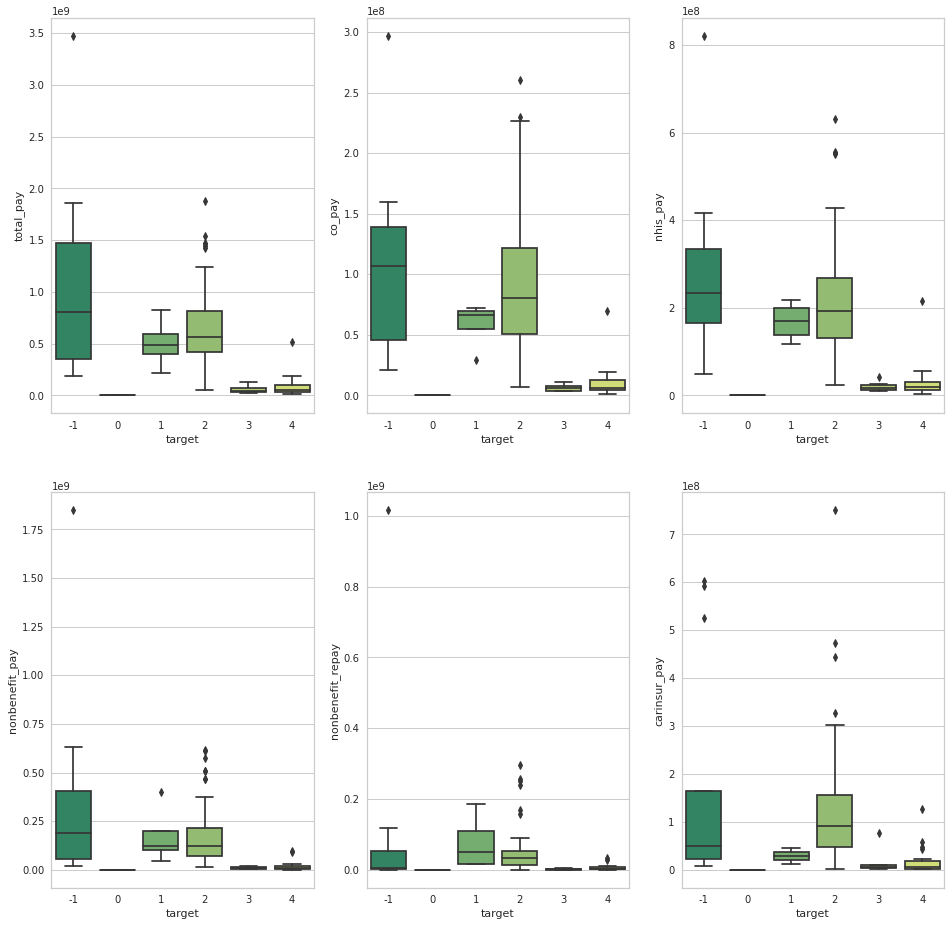

In [39]:
fig, axes = plt.subplots(2,3,figsize=(16,16))


sns.boxplot(ax=axes[0,0], data=df_hdb, x= 'target', y='total_pay', palette='summer')
sns.boxplot(ax=axes[0,1], data=df_hdb, x= 'target', y='co_pay', palette='summer')
sns.boxplot(ax=axes[0,2], data=df_hdb, x= 'target', y='nhis_pay', palette='summer')
sns.boxplot(ax=axes[1,0], data=df_hdb, x= 'target', y='nonbenefit_pay', palette='summer')
sns.boxplot(ax=axes[1,1], data=df_hdb, x= 'target', y='nonbenefit_repay', palette='summer')
sns.boxplot(ax=axes[1,2], data=df_hdb, x= 'target', y='carinsur_pay', palette='summer')